# 1. PARAMETERS

In [2]:
####### CONFIGURATION

class CFG:

    # environment
    environment  = 'kaggle'  # work environment ['kaggle', 'local', 'colab]
    device       = 'GPU'    # training device ['GPU', 'TPU']
    device_index = 0        # device index (when using single device)
    num_devices  = 1        # no. GPU/TPU devices (modeling)
    cpu_workers  = 4        # no. CPU cores (data loading)

    # general
    version  = 59     # notebook version (for saving outputs)
    debug    = False  # debug mode runs 10 batches for 3 epochs
    tracking = True   # track results using neptune.ai
    seed     = 10627  # random state

    # data
    num_folds   = 5      # no. CV folds
    num_cuts    = 12     # no. target cuts for stratified split
    num_reps    = 3      # no. repititions of CV
    data_pl     = False  # False or percentage of appended pseudo-labeled data 
    max_len     = 256    # maximum sequence length 
    dynamic_pad = False  # whether to enable dynamic padding on batch level
    
    # augmentations
    p_shuffle   = 0  # probability of batch-level sentence shuffle
    noise_alpha = 0  # magnitude of noise in targets based on SD
    p_translate = 0  # probability of swapping a sentence with backtranslation
    
    # architecture
    backbone       = 'distilbert-base-uncased'  # transformer backbone   
    hidden_size    = 768                        # size of the hidden layer
    pretrained     = True                       # pretrained weights [False, True, path]
    freeze_embed   = True                       # whether to freeze the embedding layer
    freeze_layers  = 0                          # how many deep transformer layers to freeze
    init_range     = None                       # weight init range for new layers (None or float)
    hidden_dropout = 0.0                        # dropout probability on hidden layers

    # network head
    pooling        = 'mean'  # pooling technique ['default', 'cls', 'mean', 'max', 'meanmax']
    pooling_layer  = -1      # hidden layer to perform pooling
    concat_layers  = 4       # no. concatenated pooling layers starting from pooling_layer
    layer_norm_eps = 1e-7    # layer normalization epsilon
    head_dropout   = 0.0     # dropout probability in head
    
    # training
    num_epochs    = 5      # no. epochs per fold
    batch_size    = 20     # no. images per batch 
    accum_iter    = 1      # no. batches for gradient accumalation
    grad_clip     = False  # max gradient norm (False or float)
    use_fp16      = True   # mixed precision mode 
    max_batches   = False  # max no. batches per training epoch (False or int)
    batch_verbose = False  # print loss every n batches
    
    # learning rate 
    lr             = 1e-4  # starting learning rate
    decay          = 1e-3  # weight decay of optimizer (L2 regularization)
    lr_layer_decay = 0.70  # LR multiplier when going to deeper layers

    # optimizer & scheduler
    optim           = 'AdamW'   # LR optimizer ['Adam', 'AdamW', 'AdamP', 'madgrad']
    adamw_bias      = True      # AdamW param: whether to enable bias correction
    scheduler       = 'cosine'  # LR scheduler after warmup ['constant', 'linear', 'cosine']
    warmup          = 0.5         # no. epochs for warmup
    update_on_batch = True      # update LR after every batch (or epoch)
    
    # loss function
    loss_fn = 'MSE'  # loss ['MSE', 'RMSE']

    # stochastic weight averaging
    swa               = False     
    swa_start         = 5
    swa_learning_rate = 1e-4
    anneal_epochs     = 3 
    anneal_strategy   = 'cos'
    
    # inference
    eval_step        = 4     # no. batches before evaluation (False or int)
    predict_oof      = True  # whether to produce OOF predictions
    predict_test     = True  # whether to produce test predictions 
    valid_batch_size = 32    # no. cases per batch 

In [3]:
####### CONVERT CONFIGURATION

CFG = dict(vars(CFG))
for key in ['__dict__', '__doc__', '__module__', '__weakref__']:
    del CFG[key]

In [4]:
####### UPDATES FOR DEBUG MODE

if CFG['debug']:
    CFG['predict_test'] = False
    CFG['tracking']     = False
    CFG['num_epochs']   = 2
    CFG['num_folds']    = 2
    CFG['num_reps']     = 1

# 2. PREPARATIONS

In [5]:
####### COLAB SETUP

import os
if (CFG['environment'] == 'colab') and (not os.path.exists('/content/input/')):

    # connect Drive
    from google.colab import drive
    drive.mount('/content/drive')  

    # copy data
    !cp -a '/content/drive/MyDrive/Competitions/readability/input' '/content'
    !cp -a '/content/drive/MyDrive/Competitions/readability/code' '/content'

In [6]:
####### PACKAGES

if CFG['environment'] != 'local':
    !pip install timm transformers accelerate adamp madgrad
    !pip install --upgrade neptune-client
    !pip install --upgrade --force-reinstall --no-deps -q kaggle
    
if CFG['device'] == 'TPU':
    !pip install cloud-tpu-client==0.10 'https://storage.googleapis.com/tpu-pytorch/wheels/torch_xla-1.8-cp37-cp37m-linux_x86_64.whl'

import numpy as np
import pandas as pd

import torch

import os
import sys
import time
import pickle

from tqdm.auto import tqdm

from sklearn import metrics
from sklearn.metrics import confusion_matrix, roc_auc_score, mean_squared_error
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold

from accelerate import notebook_launcher

import warnings
import gc; gc.enable()

     |████████████████████████████████| 376 kB 1.1 MB/s 
     |████████████████████████████████| 49 kB 3.1 MB/s 
  Created wheel for adamp: filename=adamp-0.3.0-py3-none-any.whl size=5998 sha256=3feefdf2da0e535aafda2ebc733c82166af07d06ae9985fbafed90a72e6243d0
  Stored in directory: /root/.cache/pip/wheels/bb/95/21/ced2d2cb9944e3a72e58fece7958973eed3fd8d0aeb6e2e450
Successfully built adamp
You should consider upgrading via the '/opt/conda/bin/python3.7 -m pip install --upgrade pip' command.
     |████████████████████████████████| 243 kB 1.1 MB/s 
     |████████████████████████████████| 67 kB 3.2 MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.10.2-py2.py3-none-any.whl size=424890 sha256=1d6a4c1c8e0eca29ec4f2d8e6daa18ae52d653f35d53ad874f417211d7f6be5c
  Stored in directory: /root/.cache/pip/wheels/e9/ac/d7/15fa2be10dc2b4aee3d51d94e3ad1a62ae11642ae7a51f571a
  Created wheel for strict-rfc3339: filename=strict_rfc3339-0.7-py3-none-any.whl size=18119 sha256=c1d1a1f082e6bb

In [7]:
####### MODULES

# source
if CFG['environment'] == 'local':
    sys.path.append('../code')  
elif CFG['environment'] == 'colab':
    sys.path.append('/content/code')  
elif CFG['environment'] == 'kaggle':
    sys.path.append('../input/readability-code')  

# utilities
from utilities import *

# training and inference
from run_training import run_training
from run_inference import run_inference

# visualiztion
from sample_batch import sample_batch

In [8]:
####### WORKING PATHS

if CFG['environment'] == 'local':
    CFG['data_path']  = '../input/'
    CFG['out_path']   = '../output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])
        
elif CFG['environment'] == 'kaggle':
    CFG['data_path']  = '../input/commonlitreadabilityprize/'
    CFG['out_path']   = ''

elif CFG['environment'] == 'colab':
    CFG['data_path']  = '/content/input/'
    CFG['out_path']   = '/content/drive/MyDrive/Competitions/readability/output/v' + str(CFG['version']) + '/'
    if not os.path.exists(CFG['out_path']):
        os.mkdir(CFG['out_path'])

In [9]:
####### TRACKING WITH NEPTUNE

if CFG['tracking']:
    import neptune 
    neptune.init(api_token = 'you-api-token',
                 project_qualified_name = 'your-project')
    neptune.create_experiment(name = 'v' + str(CFG['version']), params = CFG) 

https://app.neptune.ai/ml_comps/readability/e/READ-448


In [10]:
####### SETTINGS

warnings.filterwarnings('ignore')       # ignoring warnings
pd.options.display.max_columns = 100    # maximum displayed columns
torch.backends.cudnn.benchmark = False  # set to True if NN inputs are the same size
seed_everything(CFG['seed'])            # random seed

- setting random seed to 10627...


# 3. DATA PREP

In [11]:
####### TRAIN DATA PROCESSING

# import
df = pd.read_csv(CFG['data_path'] + 'train.csv')

# check max length
from tokenizer import get_tokenizer
tokenizer = get_tokenizer(CFG)
df['seq_length'] = df['excerpt'].apply(lambda x: len(tokenizer(x)['input_ids']))
print('maximum length: {}'.format(max(df['seq_length'])))

# partitioning
df['target_cat'] = pd.cut(df['target'], CFG['num_cuts'], labels = False)
for i in range(CFG['num_reps']):
    folds = StratifiedKFold(n_splits = CFG['num_folds'], shuffle = True, random_state = CFG['seed'] - i)
    for fold_idx, (trn_idx, val_idx) in enumerate(folds.split(df, df['target_cat'])):
        df.loc[val_idx, 'fold' + str(i)] = int(fold_idx)
    df['fold' + str(i)] = df['fold' + str(i)].astype(int)
             
# display
print('train shape: {}'.format(df.shape))
display(df.head())

Downloading:   0%|          | 0.00/442 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

maximum length: 314
train shape: (2834, 11)


,id,url_legal,license,excerpt,target,standard_error,seq_length,target_cat,fold0,fold1,fold2
0,c12129c31,NaN,NaN,When the young people returned to the ballroom...,-0.340259,0.464009,220,7,1,3,1
1,85aa80a4c,NaN,NaN,"All through dinner time, Mrs. Fayre was somewh...",-0.315372,0.480805,243,7,0,3,1
2,b69ac6792,NaN,NaN,"As Roger had predicted, the snow departed as q...",-0.580118,0.476676,229,6,4,0,3
3,dd1000b26,NaN,NaN,And outside before the palace a great garden w...,-1.054013,0.450007,220,5,3,2,0
4,37c1b32fb,NaN,NaN,Once upon a time there were Three Bears who li...,0.247197,0.510845,186,8,1,2,2


In [12]:
####### TEST DATA PROCESSING

# import
sub = pd.read_csv(CFG['data_path'] + 'test.csv')

# subset if debug
if CFG['debug']:
    sub = sub.head(CFG['valid_batch_size'])

# display
print('test shape: {}'.format(sub.shape))
display(sub.head())

test shape: (7, 4)


,id,url_legal,license,excerpt
0,c0f722661,NaN,NaN,My hope lay in Jack's promise that he would ke...
1,f0953f0a5,NaN,NaN,Dotty continued to go to Mrs. Gray's every nig...
2,0df072751,NaN,NaN,It was a bright and cheerful scene that greete...
3,04caf4e0c,https://en.wikipedia.org/wiki/Cell_division,CC BY-SA 3.0,Cell division is the process by which a parent...
4,0e63f8bea,https://en.wikipedia.org/wiki/Debugging,CC BY-SA 3.0,Debugging is the process of finding and resolv...


In [13]:
###### SHOW SAMPLE BATCH

_ = sample_batch(CFG, df, sample_size = 5, seq_size = 15, batch_idx = 2)

- setting random seed to 10627...
- loading time: 0.0851 vs 0.0635 seconds
- inputs shape: torch.Size([5, 256]) vs torch.Size([5, 256])
----------------------------------------------------------------------------------------------------
101, 5916, 15983, 2001, 2908, 1010, 10508, 2001, 2908, 1012, 1996, 2282, 2001, 3243, 4064 |           -3.081337118
101, 2009, 2001, 3373, 2011, 1996, 4054, 2273, 1997, 3448, 2008, 14838, 1005, 1055, 25353 |           -2.145248365
101, 1996, 5119, 1999, 1037, 3518, 2277, 4930, 1996, 3178, 1997, 2048, 1012, 1996, 2181 |           -1.400318025
101, 1996, 3750, 2939, 12531, 2039, 1998, 2091, 1996, 2146, 1010, 2659, 1011, 8292, 18450 |           -0.495298635
101, 2023, 21877, 7265, 4360, 2015, 2001, 10920, 1011, 2048, 2086, 2214, 1012, 2002, 2001 |    0.24580570899999998
----------------------------------------------------------------------------------------------------
[CLS] it was believed by the principal men of virginia that talbot's sy     |           -

# 4. CROSS-VALIDATION

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------


Downloading:   0%|          | 0.00/268M [00:00<?, ?B/s]

- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7657 | val_loss = 0.2869 | val_score = 0.5357 | 2.25 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2784 | val_loss = 0.2487 | val_score = 0.4987 | 2.03 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1670 | val_loss = 0.2343 | val_score = 0.4841 | 2.04 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.1024 | val_loss = 0.2289 | val_score = 0.4784 | 2.04 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0672 | val_loss = 0.2327 | val_score = 0.4824 | 2.00 min
-------------------------------------------------------
Best: score = 0.4784 (epoch 4)
-------------------------------------------------------


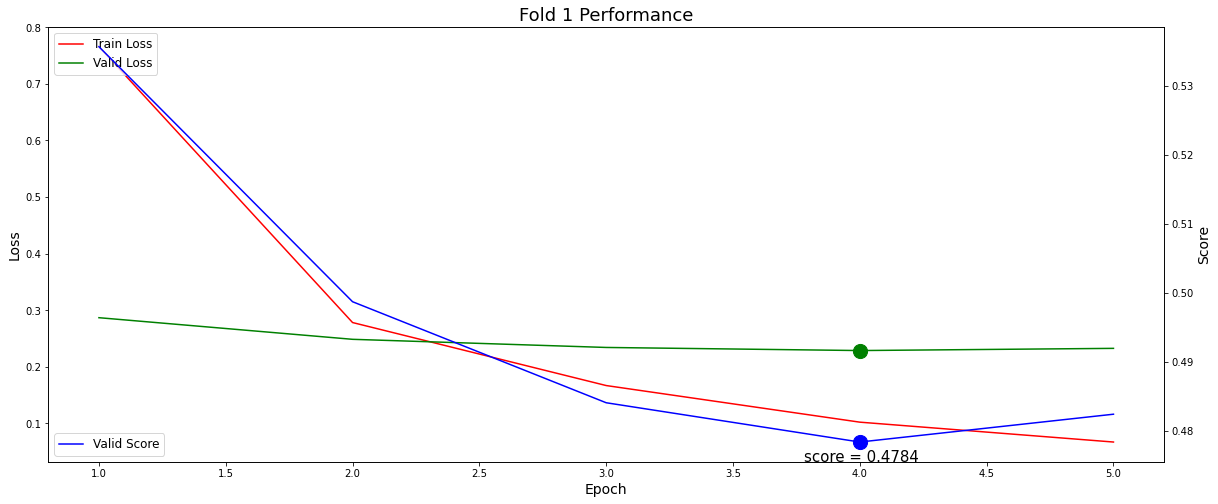

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7674 | val_loss = 0.3142 | val_score = 0.5605 | 2.18 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2930 | val_loss = 0.2782 | val_score = 0.5274 | 2.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1781 | val_loss = 0.2499 | val_score = 0.4999 | 2.06 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0993 | val_loss = 0.2508 | val_score = 0.5008 | 2.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0692 | val_loss = 0.2466 | val_score = 0.4965 | 2.03 min
-------------------------------------------------------
Best: score = 0.4965 (epoch 5)
-------------------------------------------------------


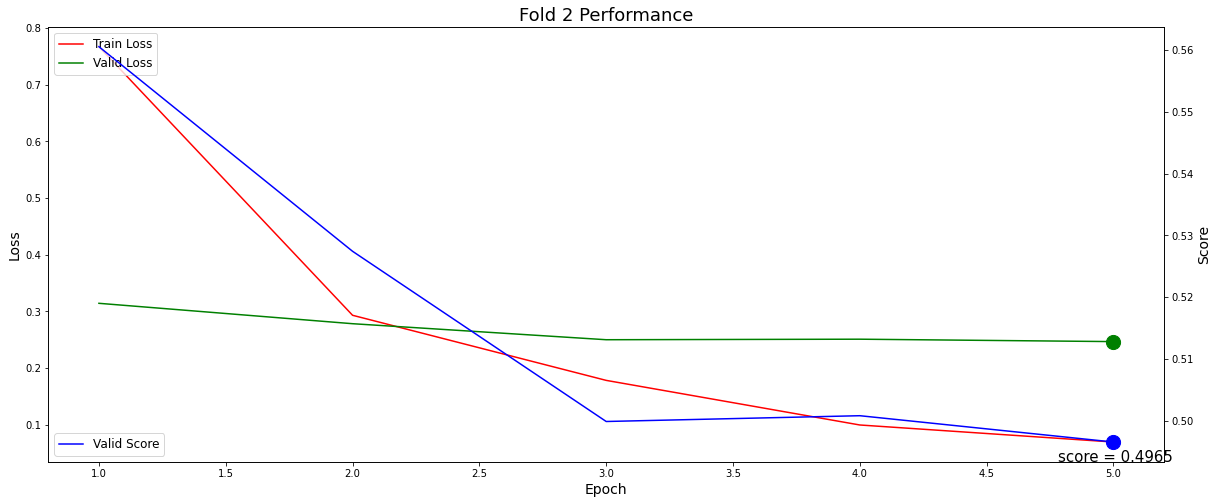

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.6420 | val_loss = 0.3370 | val_score = 0.5805 | 2.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2798 | val_loss = 0.2700 | val_score = 0.5196 | 2.06 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1690 | val_loss = 0.2562 | val_score = 0.5061 | 2.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0900 | val_loss = 0.2590 | val_score = 0.5090 | 2.00 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0637 | val_loss = 0.2588 | val_score = 0.5087 | 2.00 min
-------------------------------------------------------
Best: score = 0.5061 (epoch 3)
-------------------------------------------------------


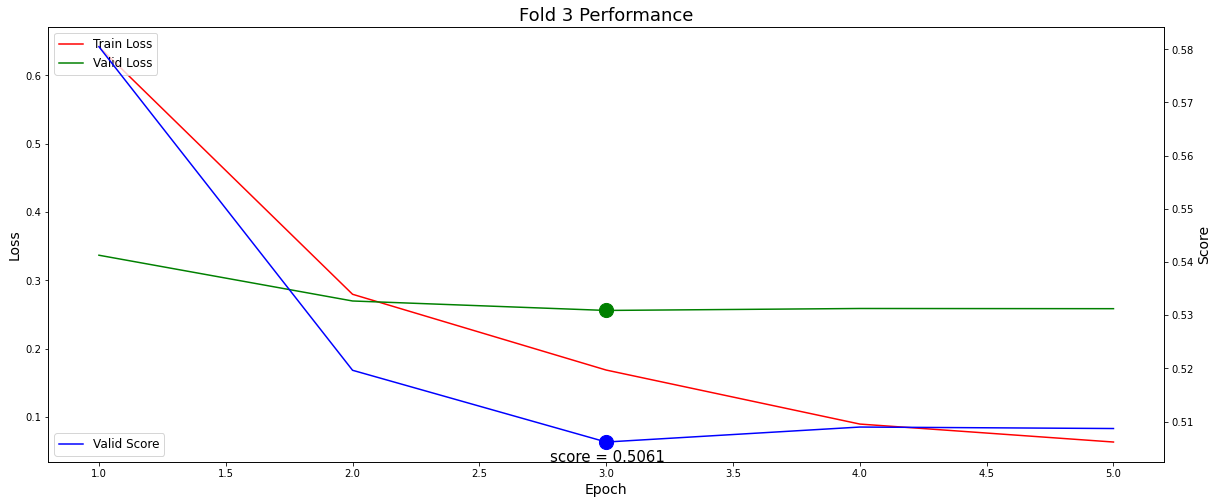

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8021 | val_loss = 0.3337 | val_score = 0.5777 | 2.20 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2937 | val_loss = 0.2798 | val_score = 0.5289 | 2.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1749 | val_loss = 0.2589 | val_score = 0.5088 | 2.13 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.1150 | val_loss = 0.2570 | val_score = 0.5070 | 2.03 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0763 | val_loss = 0.2577 | val_score = 0.5076 | 2.01 min
-------------------------------------------------------
Best: score = 0.5070 (epoch 4)
-------------------------------------------------------


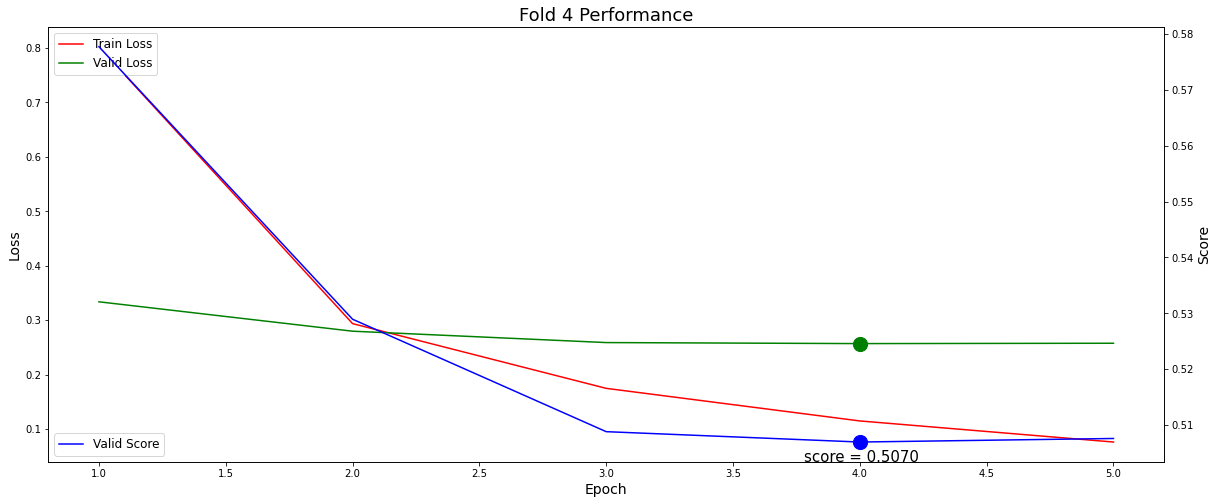

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------
- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7828 | val_loss = 0.3239 | val_score = 0.5692 | 2.22 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2582 | val_loss = 0.2683 | val_score = 0.5180 | 2.11 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1593 | val_loss = 0.2538 | val_score = 0.5037 | 2.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0838 | val_loss = 0.2486 | val_score = 0.4986 | 2.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0571 | val_loss = 0.2513 | val_score = 0.5013 | 2.01 min
-------------------------------------------------------
Best: score = 0.4986 (epoch 4)
-------------------------------------------------------


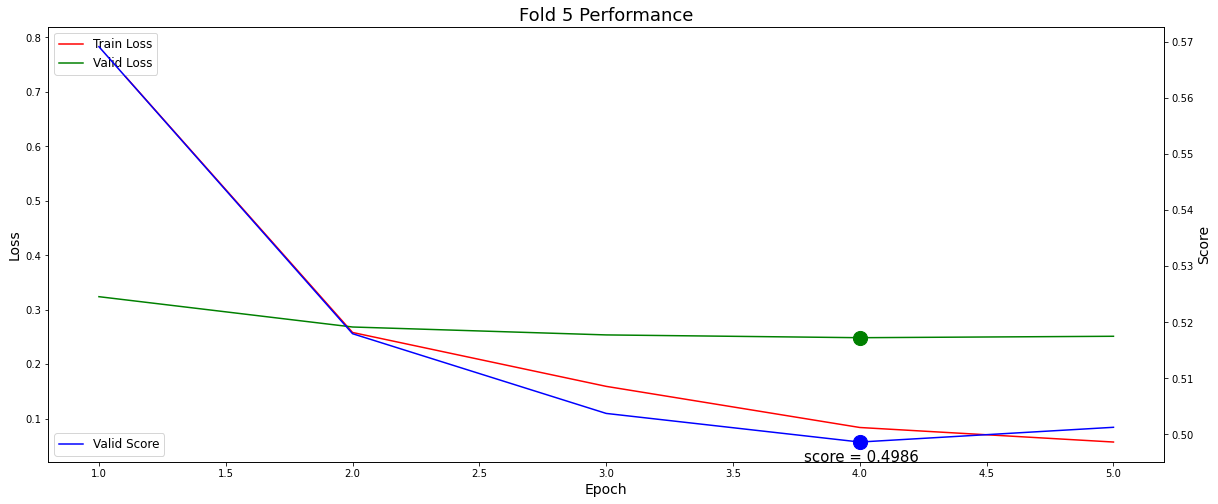

-------------------------------------------------------
REP 1/3 | OOF score = 0.4973
-------------------------------------------------------

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7501 | val_loss = 0.2944 | val_score = 0.5426 | 2.27 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2875 | val_loss = 0.2704 | val_score = 0.5200 | 2.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1767 | val_loss = 0.2477 | val_score = 0.4977 | 2.09 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0983 | val_loss = 0.2454 | val_score = 0.4954 | 2.03 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0683 | val_loss = 0.2496 | val_score = 0.4996 | 2.01 min
-------------------------------------------------------
Best: score = 0.4954 (epoch 4)
-------------------------------------------------------


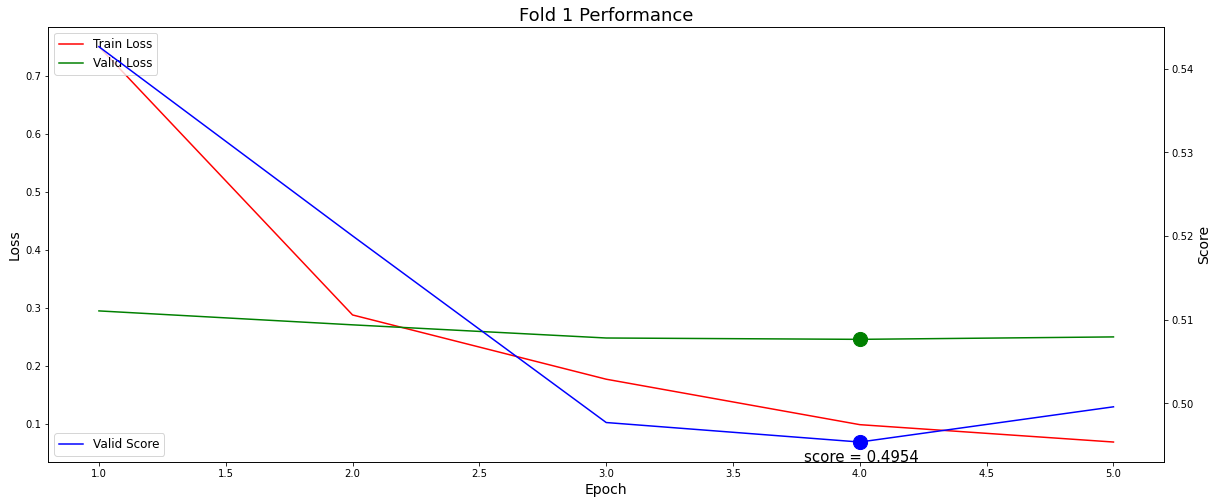

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8022 | val_loss = 0.3351 | val_score = 0.5789 | 2.19 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2799 | val_loss = 0.2853 | val_score = 0.5341 | 2.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1590 | val_loss = 0.2694 | val_score = 0.5191 | 2.05 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0984 | val_loss = 0.2676 | val_score = 0.5173 | 2.03 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0644 | val_loss = 0.2661 | val_score = 0.5158 | 2.03 min
-------------------------------------------------------
Best: score = 0.5158 (epoch 5)
-------------------------------------------------------


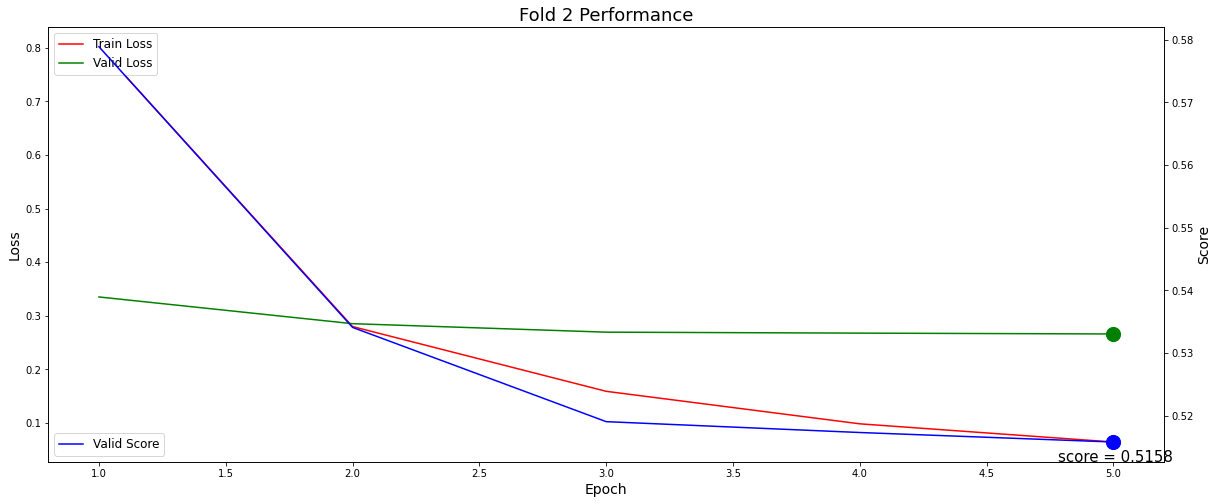

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5956 | val_loss = 0.2985 | val_score = 0.5464 | 2.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2675 | val_loss = 0.2486 | val_score = 0.4986 | 2.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1476 | val_loss = 0.2429 | val_score = 0.4928 | 2.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0827 | val_loss = 0.2438 | val_score = 0.4937 | 2.01 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0529 | val_loss = 0.2427 | val_score = 0.4926 | 2.02 min
-------------------------------------------------------
Best: score = 0.4926 (epoch 5)
-------------------------------------------------------


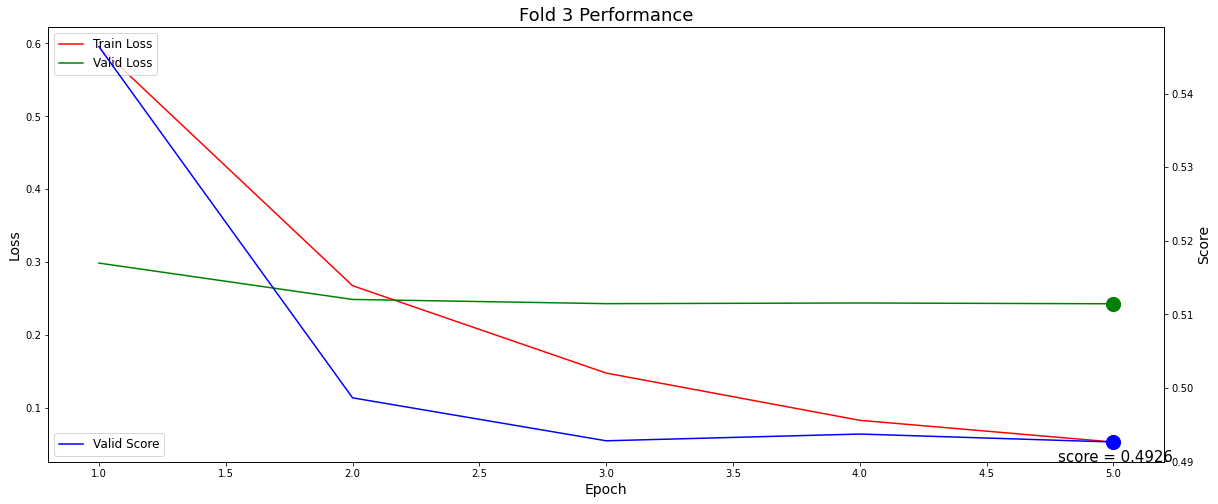

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7589 | val_loss = 0.3235 | val_score = 0.5688 | 2.26 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2681 | val_loss = 0.2677 | val_score = 0.5174 | 2.14 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1542 | val_loss = 0.2537 | val_score = 0.5037 | 2.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0880 | val_loss = 0.2542 | val_score = 0.5041 | 2.01 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0585 | val_loss = 0.2611 | val_score = 0.5110 | 2.01 min
-------------------------------------------------------
Best: score = 0.5037 (epoch 3)
-------------------------------------------------------


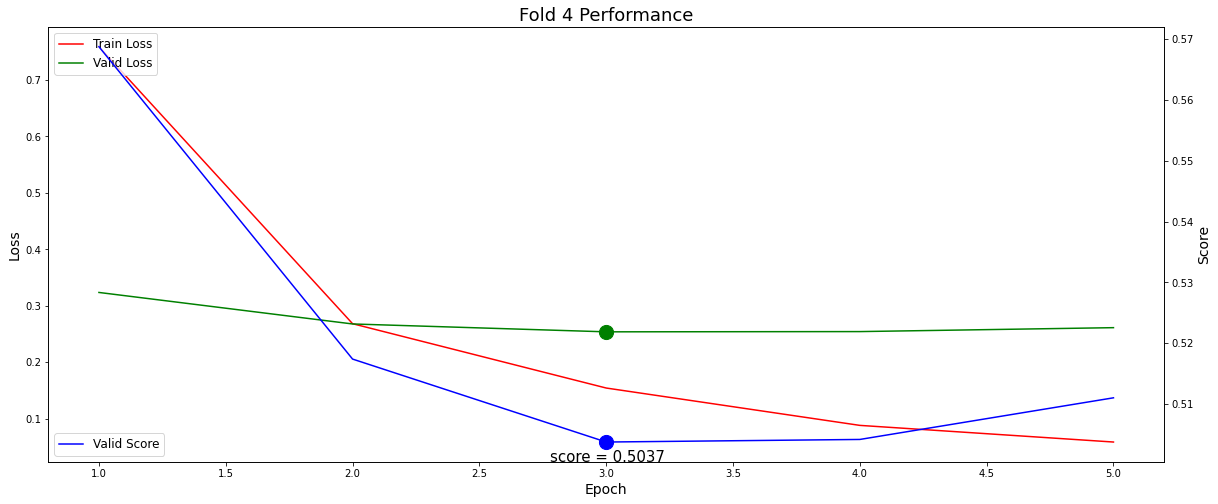

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------
- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8420 | val_loss = 0.3263 | val_score = 0.5712 | 2.21 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2944 | val_loss = 0.2778 | val_score = 0.5270 | 2.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1734 | val_loss = 0.2542 | val_score = 0.5042 | 2.11 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0966 | val_loss = 0.2467 | val_score = 0.4967 | 2.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0695 | val_loss = 0.2526 | val_score = 0.5026 | 2.00 min
-------------------------------------------------------
Best: score = 0.4967 (epoch 4)
-------------------------------------------------------


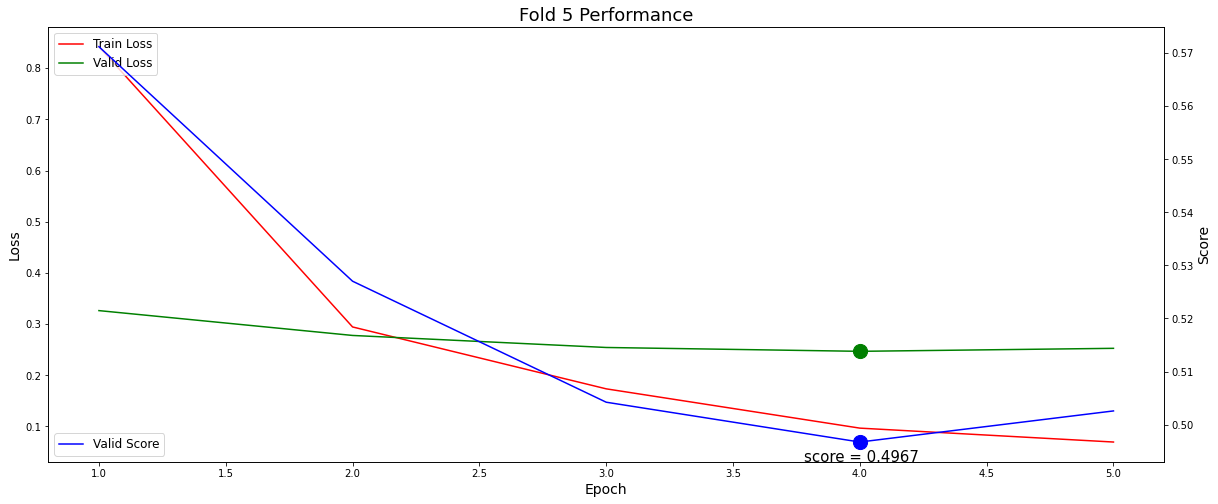

-------------------------------------------------------
REP 2/3 | OOF score = 0.5009
-------------------------------------------------------

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7424 | val_loss = 0.3244 | val_score = 0.5695 | 2.27 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2695 | val_loss = 0.2596 | val_score = 0.5095 | 2.12 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1668 | val_loss = 0.2398 | val_score = 0.4897 | 2.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0928 | val_loss = 0.2348 | val_score = 0.4846 | 2.04 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0656 | val_loss = 0.2425 | val_score = 0.4924 | 2.01 min
-------------------------------------------------------
Best: score = 0.4846 (epoch 4)
-------------------------------------------------------


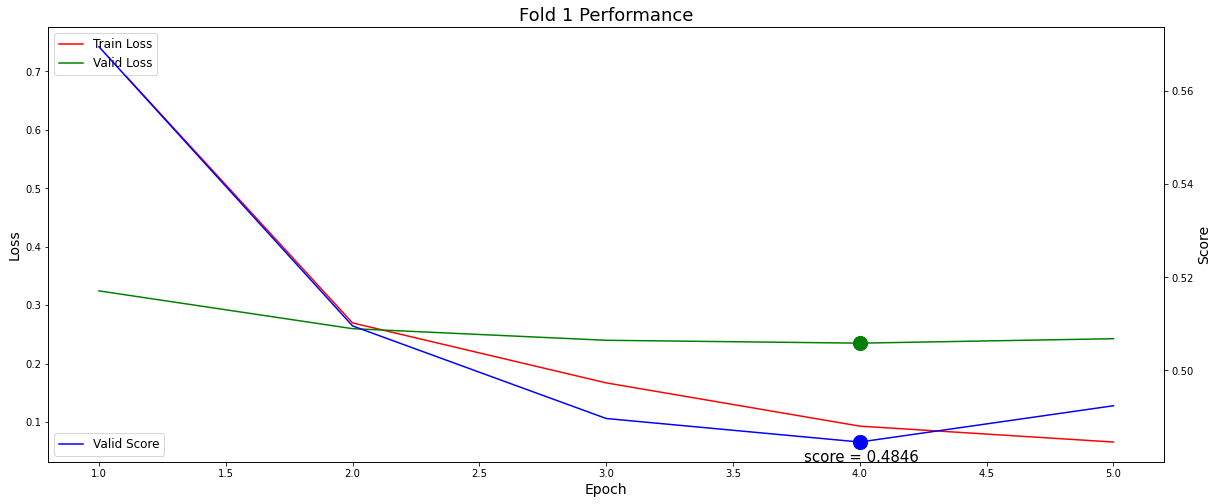

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8040 | val_loss = 0.3228 | val_score = 0.5681 | 2.16 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2997 | val_loss = 0.2615 | val_score = 0.5114 | 2.10 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1689 | val_loss = 0.2496 | val_score = 0.4996 | 2.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0966 | val_loss = 0.2477 | val_score = 0.4977 | 2.03 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0666 | val_loss = 0.2517 | val_score = 0.5017 | 2.00 min
-------------------------------------------------------
Best: score = 0.4977 (epoch 4)
-------------------------------------------------------


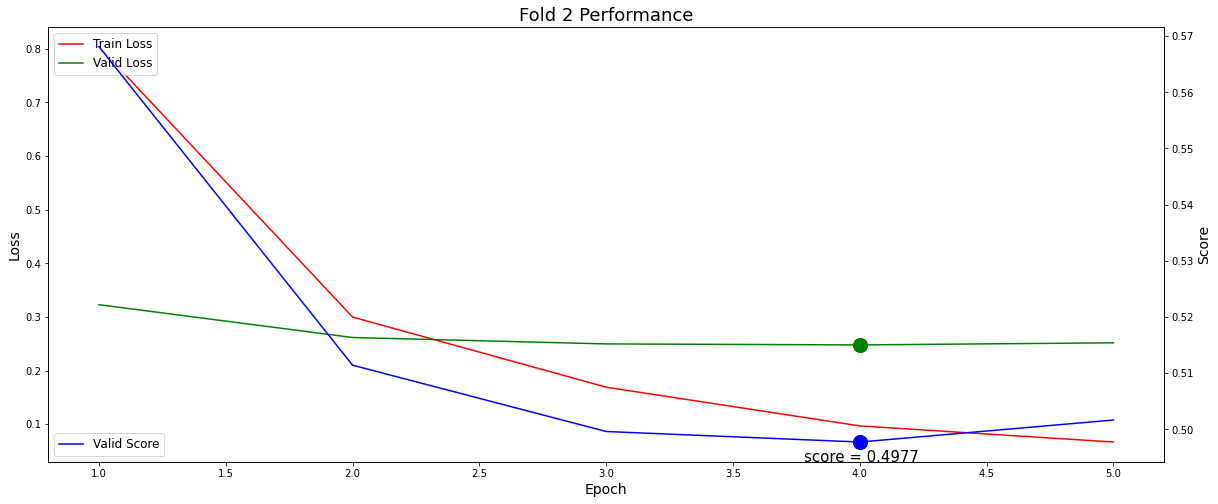

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.5924 | val_loss = 0.2905 | val_score = 0.5390 | 2.27 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2972 | val_loss = 0.2550 | val_score = 0.5049 | 2.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1663 | val_loss = 0.2362 | val_score = 0.4860 | 2.12 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0946 | val_loss = 0.2308 | val_score = 0.4804 | 2.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0682 | val_loss = 0.2349 | val_score = 0.4847 | 2.01 min
-------------------------------------------------------
Best: score = 0.4804 (epoch 4)
-------------------------------------------------------


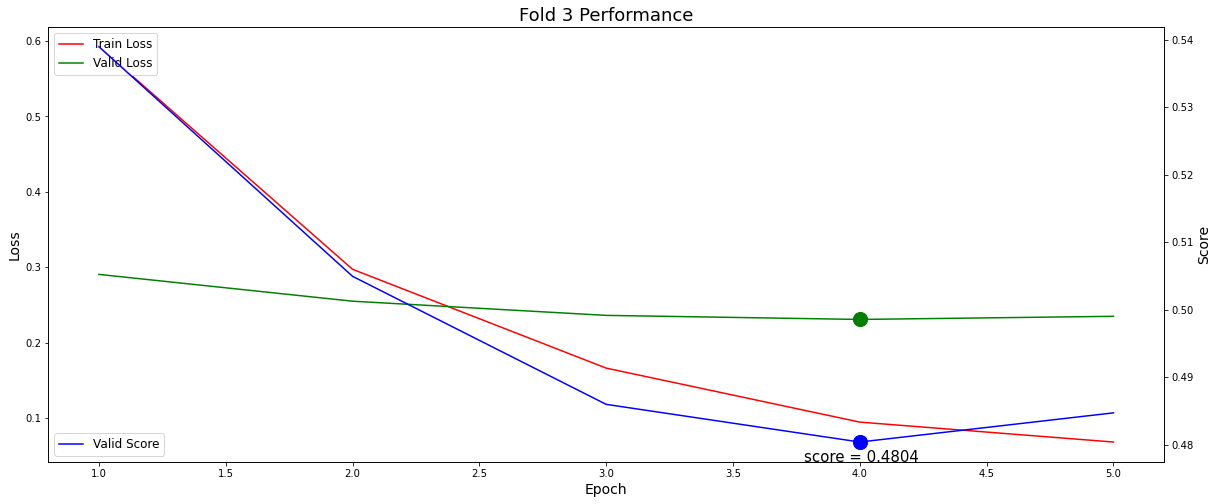

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------
- no. observations: train - 2267, valid - 567


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.7391 | val_loss = 0.3183 | val_score = 0.5642 | 2.28 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2699 | val_loss = 0.2648 | val_score = 0.5146 | 2.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1584 | val_loss = 0.2504 | val_score = 0.5004 | 2.08 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0898 | val_loss = 0.2499 | val_score = 0.4999 | 2.03 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0617 | val_loss = 0.2470 | val_score = 0.4970 | 2.03 min
-------------------------------------------------------
Best: score = 0.4970 (epoch 5)
-------------------------------------------------------


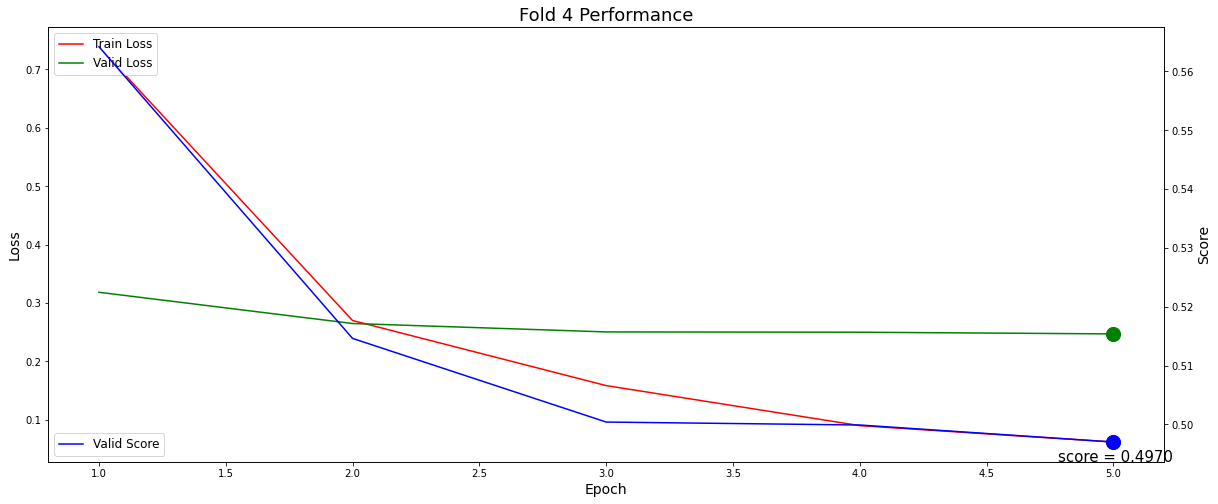

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------
- no. observations: train - 2268, valid - 566


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 1/5 | lr = 0.000971 | trn_loss = 0.8535 | val_loss = 0.3248 | val_score = 0.5699 | 2.24 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 2/5 | lr = 0.000753 | trn_loss = 0.2614 | val_loss = 0.2820 | val_score = 0.5311 | 2.11 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 3/5 | lr = 0.000416 | trn_loss = 0.1592 | val_loss = 0.2634 | val_score = 0.5132 | 2.06 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 4/5 | lr = 0.000119 | trn_loss = 0.0918 | val_loss = 0.2573 | val_score = 0.5073 | 2.07 min


  0%|          | 0/114 [00:00<?, ?it/s]

-- epoch 5/5 | lr = 0.000000 | trn_loss = 0.0628 | val_loss = 0.2568 | val_score = 0.5068 | 2.03 min
-------------------------------------------------------
Best: score = 0.5068 (epoch 5)
-------------------------------------------------------


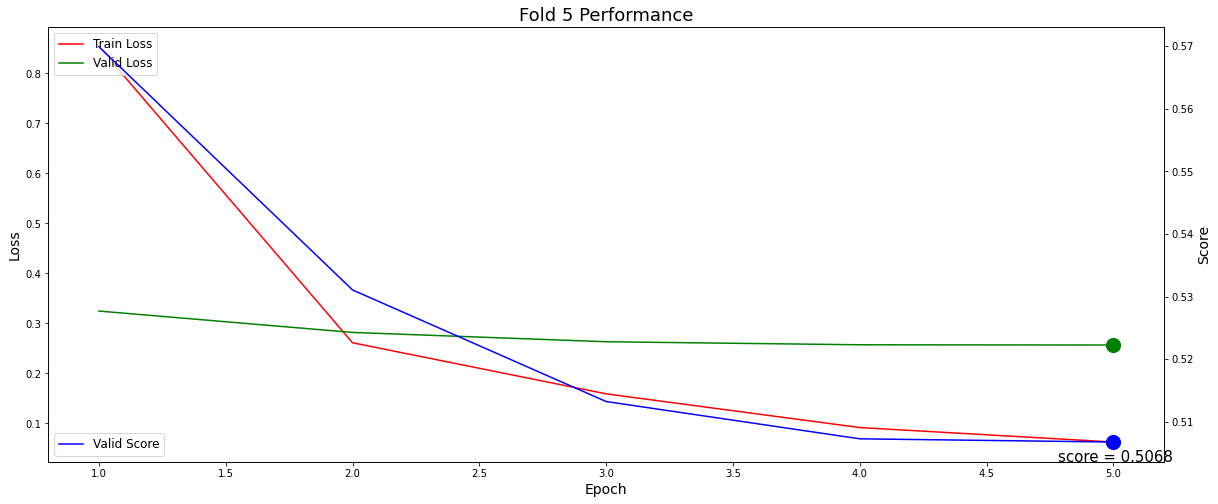

-------------------------------------------------------
REP 3/3 | OOF score = 0.4933
-------------------------------------------------------

-------------------------------------------------------
Mean OOF score = 0.4972
-------------------------------------------------------

Finished in 158.17 minutes


In [14]:
####### CROSS-VALIDATION LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_training,
                  args          = (df, CFG),
                  num_processes = CFG['num_devices'],
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

# 5. INFERENCE

In [15]:
####### INFERENCE LOOP

# timer
cv_start = time.time()

# run cross-validation
print('-' * 55)
notebook_launcher(function      = run_inference,
                  args          = (df, sub, CFG),
                  num_processes = 1,
                  use_fp16      = CFG['use_fp16'])

# clear memory
gc.collect()
torch.cuda.empty_cache()

# feedback
print('')
print('Finished in {:.2f} minutes'.format((time.time() - cv_start) / 60))

-------------------------------------------------------
Launching training on one GPU.
-------------------------------------------------------
REP 1/3 | FOLD 1/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 2/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 3/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 4/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 1/3 | FOLD 5/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 1/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 2/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 3/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 4/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 2/3 | FOLD 5/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 1/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 2/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 3/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 4/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

-------------------------------------------------------
REP 3/3 | FOLD 5/5
-------------------------------------------------------
-- loaded custom weights


  0%|          | 0/18 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]


Finished in 2.29 minutes


In [16]:
####### CHECK OOF PERFORMANCE

# import OOF
oof = pd.read_csv(CFG['out_path'] + 'oof.csv')

# compute score
oof_score = []
for rep in range(CFG['num_reps']):
    oof_score.append(get_score(oof['target'], oof['pred_rep' + str(rep)]))
CFG['oof_score'] = np.mean(oof_score)

# compute bag score
blend = 'amean'
oof['blend']     = compute_blend(oof, ['pred_rep' + str(rep) for rep in range(CFG['num_reps'])], blend, CFG)
CFG['bag_score'] = get_score(oof['target'], oof['blend'])

# print performance
print('-' * 22)
print('OOF score     = {:.4f}'.format(CFG['oof_score']))
print('OOF bag score = {:.4f}'.format(CFG['bag_score']))
print('-' * 22)

----------------------
OOF score     = 0.4973
OOF bag score = 0.4901
----------------------


In [17]:
####### EXPORT CONFIGURATION

# save dictionary
pickle.dump(CFG, open(CFG['out_path'] + 'configuration.pkl', 'wb'))

# send data to Neptune
if CFG['tracking']:
    neptune.send_metric('oof_score', CFG['oof_score'])
    neptune.send_metric('bag_score', CFG['bag_score'])
    neptune.send_artifact(CFG['out_path'] + 'configuration.pkl')
    neptune.stop()